## Satisfactory Reviews - An NLP Project

Earlier this year, I discovered a wonderful game named Satisfactory. I immediately fell in love with the concept of landing on an unknown planet, where the only goal is to use the planet's resources to build the ultimate factory. With a huge map jampacked with resouces, aliens and poisonous clouds (and lizard doggos!) - one has to locate resources, build factories, and spend a *ridiculous* amount of time just making the process more efficient. 

<center><img src="sf-banner.jpg" width="750" height="500" align="center"/>

    
    
As a data scientist (who willingly spent a ridiculous amount of time increasing the efficiency of everything), I needed to know what others had to say about this game. I built a webscraper that took in user reviews of Satisfactory from the Steam community website, and pulled around 6000 reviews from the past few months since the last major update (which was in March 2021, Update #4, as of this project's creation). 

I wanted to focus on those that wrote a review, recommended (or not), the length of the review, and how long they've played the game. Using this data, we'll be able to draw insights into what are words commonly said across all reviews, and determine if the length of time played in the game affects their recommendation or not. 

Also, have I mentioned the DOGGOS!? 

<center><img src="lizard-doggo.png" width="750" height="500" align="center"/>


Before we get lost in the incredible cuteness of the doggos, we'll start by pulling in all the relevant libraries first. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import re
import emoji
import string
import collections
import unicodedata
import gensim.corpora as corpora 
import gensim 
from gensim.utils import simple_preprocess
from pprint import pprint
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.base import BaseEstimator, TransformerMixin

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# set theme style for plots
plt.style.use('ggplot')

C:\Users\Katya\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# reading in the dataframe
df = pd.read_csv(r"C:\Users\Katya\Documents\GitHub\SF-Project\Steam_Reviews_Aug_2021.csv")

# take a quick peek
df.head(10)

,SteamId,ProfileURL,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted
0,7.65612E+16,https://steamcommunity.com/profiles/7656119884...,EARLY ACCESS REVIEW\r\n0yuyou9yfui9ftrygyg6ftd...,Recommended,59,36.6 hrs on record,Posted: August 3
1,7.65612E+16,https://steamcommunity.com/profiles/7656119829...,EARLY ACCESS REVIEW\r\nHm.I think it's a good ...,Recommended,40,24.3 hrs on record,Posted: August 3
2,7.65612E+16,https://steamcommunity.com/profiles/7656119816...,EARLY ACCESS REVIEW\r\nI uhh....... already fe...,Recommended,59,21.7 hrs on record,Posted: August 3
3,7.65612E+16,https://steamcommunity.com/profiles/7656119820...,"EARLY ACCESS REVIEW\r\nIts pretty cool, really...",Recommended,60,4.4 hrs on record,Posted: August 3
4,7.65612E+16,https://steamcommunity.com/profiles/7656119907...,EARLY ACCESS REVIEW\r\nvery good,Recommended,26,5.6 hrs on record,Posted: August 3
5,7.65612E+16,https://steamcommunity.com/profiles/7656119831...,EARLY ACCESS REVIEW\r\nThe game where u watch ...,Recommended,106,216.7 hrs on record,Posted: August 3
6,7.65612E+16,https://steamcommunity.com/profiles/7656119903...,EARLY ACCESS REVIEW\r\nIt's addicting!,Recommended,32,403.6 hrs on record,Posted: August 3
7,7.65612E+16,https://steamcommunity.com/profiles/7656119904...,EARLY ACCESS REVIEW\r\nThis game is already in...,Recommended,88,77.9 hrs on record,Posted: August 3
8,burakyilmaz,https://steamcommunity.com/id/burakyilmaz/,"EARLY ACCESS REVIEW\r\nIf you like automation,...",Recommended,213,393.0 hrs on record,Posted: August 3
9,Merleo,https://steamcommunity.com/id/Merleo/,EARLY ACCESS REVIEW\r\nAfter the fun i have be...,Recommended,875,76.9 hrs on record,Posted: August 3


### Data Dictionary 

The dataframe contains information from a few points of view: 

- `SteamID`: The steam ID of the player
- `ProfileURL`: The link to the profile of the player
- `ReviewText`: The review text content 
- `Review`: Shows whether if the player recommends this game or not 
- `ReviewLength(Chars)`: The length of the review
- `PlayHours`: The amount of hours played 
- `DatePosted`: When the review was posted 

### Basic Cleaning
Now that we have an idea of what columns are, we'll go ahead with some basic cleaning of the columns. Since we're not focusing on the user profiles of the customers in this project, we'll be dropping the `SteamId` and `ProfileURL` columns next. 




In [3]:
# dropping user information
df.drop(['SteamId', 'ProfileURL'], axis=1, inplace=True)

With the user information removed, we'll start with cleaning the `ReviewText` column, by removing the "EARLY ACCESS REVIEW" text at the beginning of each line. While this was being scraped from the website, the review content box also included the "Early Access Review" icon, which was collected together. 

In [4]:
# cleaning the review text column (removing the EARLY ACCESS REVIEW)
df['ReviewText'] = df['ReviewText'].str.replace('EARLY ACCESS REVIEW\r\n', '')

#sanity check
df

,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted
0,0yuyou9yfui9ftrygyg6ftdryujiouhyeasrtgf4r,Recommended,59,36.6 hrs on record,Posted: August 3
1,Hm.I think it's a good game,Recommended,40,24.3 hrs on record,Posted: August 3
2,I uhh....... already feel my body getting fatter,Recommended,59,21.7 hrs on record,Posted: August 3
3,"Its pretty cool, really slow however in the st...",Recommended,60,4.4 hrs on record,Posted: August 3
4,very good,Recommended,26,5.6 hrs on record,Posted: August 3
...,...,...,...,...,...
6175,It is such a complex grinding game :),Recommended,48,157.2 hrs on record,Posted: April 18
6176,"Terrible early access game, literally nothing ...",Recommended,63,394.7 hrs on record,Posted: April 18
6177,bean,Recommended,22,186.1 hrs on record,Posted: April 18
6178,This game tells me that i have too much free time,Recommended,57,143.8 hrs on record,Posted: April 18


Before getting deeper with text cleaning using the NLTK library, we'll also have some other columns that need paying attention to. Namely, `DatePosted` has "Posted: " right before the date - this will be removed. Secondly, the `PlayHours` column contains "hrs on record" right after the number of hours. This information is not useful for us, and that will also be removed. 

In [5]:
# cleaning DatePosted to have only the dates
df['DatePosted'] = df['DatePosted'].str.replace('Posted: ', '')

# cleaning PlayHours to contain only the numerical values
df['PlayHours'] = df['PlayHours'].str.replace(' hrs on record', '')

# renaming some columns
df.rename(columns={'ReviewLength(Chars)':'CharLenOfReview'})

,ReviewText,Review,CharLenOfReview,PlayHours,DatePosted
0,0yuyou9yfui9ftrygyg6ftdryujiouhyeasrtgf4r,Recommended,59,36.6,August 3
1,Hm.I think it's a good game,Recommended,40,24.3,August 3
2,I uhh....... already feel my body getting fatter,Recommended,59,21.7,August 3
3,"Its pretty cool, really slow however in the st...",Recommended,60,4.4,August 3
4,very good,Recommended,26,5.6,August 3
...,...,...,...,...,...
6175,It is such a complex grinding game :),Recommended,48,157.2,April 18
6176,"Terrible early access game, literally nothing ...",Recommended,63,394.7,April 18
6177,bean,Recommended,22,186.1,April 18
6178,This game tells me that i have too much free time,Recommended,57,143.8,April 18


### Assigning Binary Classification to Recommendations
Next we'll use the `map()` function to assign binary values to the `Review` column (0,1) so that the data is more intrepretable. 

In [6]:
# assigning binary values for Review column (1 for Recommended, 0 for Not Recommended)
df['Review'] = df['Review'].map({'Recommended': 1, 'Not Recommended': 0})

#sanity check
df.head()

,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted
0,0yuyou9yfui9ftrygyg6ftdryujiouhyeasrtgf4r,1,59,36.6,August 3
1,Hm.I think it's a good game,1,40,24.3,August 3
2,I uhh....... already feel my body getting fatter,1,59,21.7,August 3
3,"Its pretty cool, really slow however in the st...",1,60,4.4,August 3
4,very good,1,26,5.6,August 3


Let's find out the proportion of those that recommend the game or not, and how much of the total population they represent. 

In [7]:
# counting the total number of users that recommend the game
total_recommended = df.Review[df['Review'] == 1].count()

# counting the total number of users that don't recommend the game
total_not_recommended = df.Review[df['Review'] == 0].count()

print(f"There are {total_recommended} players that recommend the game, and {total_not_recommended} that don't recommend this game.")
print("*" * 100)
print(f"Those that recommend the game account for {'{:.2f}'.format((total_recommended/len(df))*100)}% of the total.")
print(f"People who don't recommend the game account for {'{:.2f}'.format((total_not_recommended/len(df))*100)}% of the total.")

There are 5985 players that recommend the game, and 195 that don't recommend this game.
****************************************************************************************************
Those that recommend the game account for 96.84% of the total.
People who don't recommend the game account for 3.16% of the total.


Even though we know many people recommended the game or not, we don't exactly know the context of these reviews. What if someone *really* enjoyed the game, but they didn't recommend it because of some trivial things like, bugs or play time?  

There is where TextBlob comes in. We'll be able to calculate the sentiment through the polarity function, which ranges from -1 to 1 (with -1 is negative, and 1 is positive). We can also pair this up with the subjectivity function as well, which ranges from 0 to 1 (0 is objective, and 1 is subjective). We'll create our new columns, and compare if those that express positive sentiment match up with their recommendations or not. 

In [8]:
from textblob import TextBlob

df['Polarity'] = df['ReviewText'].apply(lambda x: TextBlob(x).polarity)
df['Subjective'] = df['ReviewText'].apply(lambda x: TextBlob(x).subjectivity)

In [16]:
# sanity check
df.describe()

,Review,ReviewLength(Chars),Polarity,Subjective
count,6180.000000,6180.000000,6180.000000,6180.000000
mean,0.968447,143.993366,0.142804,0.427962
std,0.174822,316.460986,0.278207,0.272566
min,0.000000,17.000000,-1.000000,0.000000
25%,1.000000,31.000000,0.000000,0.260000
50%,1.000000,57.000000,0.100000,0.479063
75%,1.000000,129.000000,0.300000,0.600000
max,1.000000,6554.000000,1.000000,1.000000


In [15]:
# filter the data frame to those that recommended the game, and have a positive sentiment
df[(df.Review == 1) & (df.Polarity > 0)].describe()

,Review,ReviewLength(Chars),Polarity,Subjective
count,3681.0,3681.000000,3.681000e+03,3681.000000
mean,1.0,163.069546,2.972529e-01,0.551676
std,0.0,327.324132,2.295499e-01,0.189789
min,1.0,17.000000,3.469447e-18,0.050000
25%,1.0,34.000000,1.298828e-01,0.445000
50%,1.0,69.000000,2.333333e-01,0.546667
75%,1.0,155.000000,4.000000e-01,0.646960
max,1.0,6124.000000,1.000000e+00,1.000000


With our new columns, let's take a closer look at the polarity and subjectivity of users that recommended the game, and have the following criteria: 
- Polarity above 0 (shows positive sentiment)
- Subjectivity above 0 (shows subjectivity, personal feelings toward the game)

In [14]:
# filter dataframe to those that recommended the gane, have positive sentiment and is subjective 
df[(df.Review == 1) & (df.Polarity > 0) & (df.Subjective > 0)].describe()

,Review,ReviewLength(Chars),Polarity,Subjective
count,3681.0,3681.000000,3.681000e+03,3681.000000
mean,1.0,163.069546,2.972529e-01,0.551676
std,0.0,327.324132,2.295499e-01,0.189789
min,1.0,17.000000,3.469447e-18,0.050000
25%,1.0,34.000000,1.298828e-01,0.445000
50%,1.0,69.000000,2.333333e-01,0.546667
75%,1.0,155.000000,4.000000e-01,0.646960
max,1.0,6124.000000,1.000000e+00,1.000000


We know that there are 5985 users that recommended the game, but only 3681 of them have a positive sentiment, as well as being subjectively honest about their experience. However, does the amount of users change if the sentiment was negative (and still recommended the game)? 

In [13]:
df[(df.Review == 1) & (df.Polarity < 0)].describe()

,Review,ReviewLength(Chars),Polarity,Subjective
count,1014.0,1014.00000,1.014000e+03,1014.000000
mean,1.0,139.32643,-1.988397e-01,0.466224
std,0.0,182.95527,1.827280e-01,0.168259
min,1.0,21.00000,-1.000000e+00,0.000000
25%,1.0,46.00000,-4.000000e-01,0.380556
50%,1.0,80.00000,-1.309028e-01,0.416167
75%,1.0,155.00000,-5.000000e-02,0.563509
max,1.0,2303.00000,-4.625929e-18,1.000000


### Exploring the Play Time of Users

The majority of users that played the game recommended the game to others. Now we'll look a little deeper into what consistutes their recommendations, and if there is a connection between their play time or not. Let's take a high level look at the statistics of users play times in hours. 

In [17]:
# lets double check the dtypes to make sure that the relevant columns are numerical
df.dtypes


ReviewText              object
Review                   int64
ReviewLength(Chars)      int64
PlayHours               object
DatePosted              object
Polarity               float64
Subjective             float64
dtype: object

The `PlayHours` column is listed as an object, we'll need to change this value to a float. We'll also be removing the comma from the column values in order to compute it a numerical value. 

In [18]:
# removing the comma from the hours column in order to change the values to a float
df.PlayHours = df.PlayHours.str.replace(',', '')

# assigning the dtype of the column to float
df.PlayHours = df.PlayHours.astype(float)

In [19]:
# grouping the recommended column, and pulling statistical information on the PlayHours such as the mean, min, max and std
df.groupby(df.Review).agg({'PlayHours': ['mean', 'min', 'max', 'std']})


PlayHours                         
              mean  min     max         std
Review                                     
0        99.226667  0.1  2034.1  235.936175
1       116.232815  0.2  4087.9  189.626862

#### Quick Overview of the Play Time of Users

The average number of hours that users logged are very similar for those that recommended the game or not. 

For those that don't recommend the game to others, the average play hours is 99.2. The highest number of hours a user has is 2034 hours, and despite such a high amount of time played these users didn't recommend the game. I'm curious as to why they would invest such a inordinate amount of time playing this game, and still not recommend it to others. The standard deviation for this group is 235.9 hours, higher than those that recommend the game (which was 189.6). This suggests that the number of hours played in this game is more spread out from the average, with more variance. 

Whereas for those that recommend the game, the average playtime is around 116.2 hours, with a max of 4087.9 hours, and a standard deviation of 189.6. With the standard deviation being lower than those that didn't recommend the game, this suggests that the values distributed are not as spread out (less variance). 

#### Quick to Judge? 
However, it seems that there are users that played the game for less than one hour as well, with both outcomes. Let's take a look at how many users played the game for only one hour or less. 

In [20]:
# filtered players that recommended the game with less than a hour of gameplay
one_hour_played_no = df.Review[(df.Review == 0) & (df.PlayHours <= 1)].count()

# filtered players that didn't recommend the game with less than a hour of gameplay
one_hour_played_yes = df.Review[(df.Review == 1) & (df.PlayHours <= 1)].count()

print(f"There are {one_hour_played_no} users that played the game for at least one hour that did NOT recommend the game.")
print(f"There are {one_hour_played_yes} users that played the game for at least one hour, and recommended the game.")

There are 16 users that played the game for at least one hour that did NOT recommend the game.
There are 12 users that played the game for at least one hour, and recommended the game.


Out of all that didn't recommend the game, only 8% of the population played the game for less than an hour. On the other hand, for those that recommened it... only 0.2% of the population immediately recommended Satisfactory from less than one hour of gameplay. 

Let's look at the distribution of the playtime for both outcomes. There are certainly some outliers for both scenarios, let's determine where they lie. 

Text(0.5, 0.98, 'Play Hours vs Polarity')

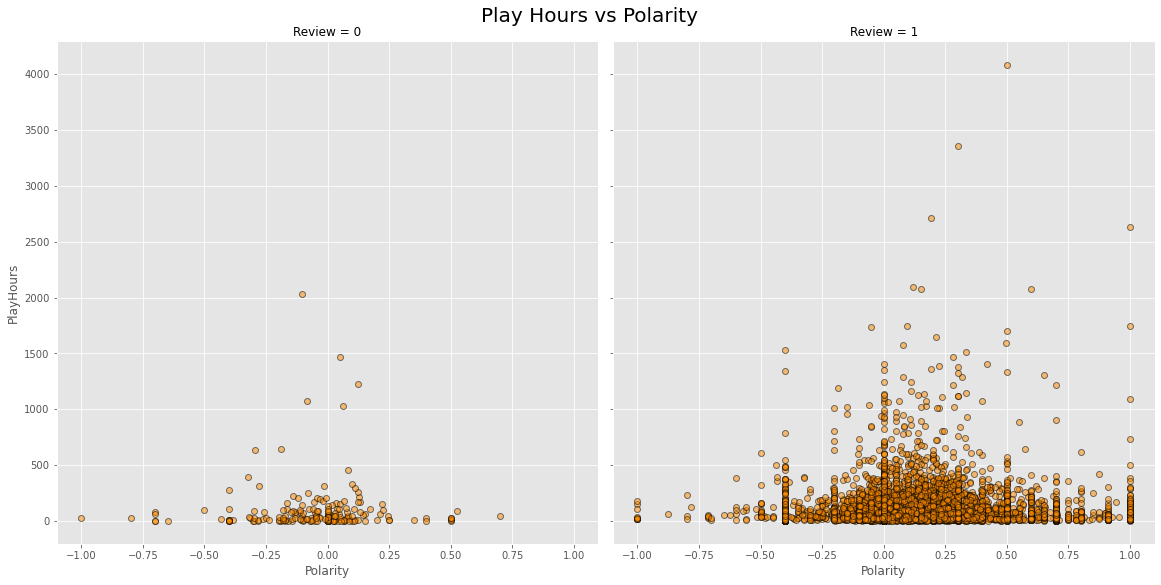

In [112]:
rel =sns.relplot(data=df, x="Polarity", y="PlayHours", col="Review", kind="scatter", height=8, aspect=1, alpha=0.5, edgecolor='black', color='darkorange', linewidth=1)
rel.fig.subplots_adjust(top=0.92)
rel.fig.suptitle('Play Hours vs Polarity', size=20)

Text(0.5, 0, 'Polarity')

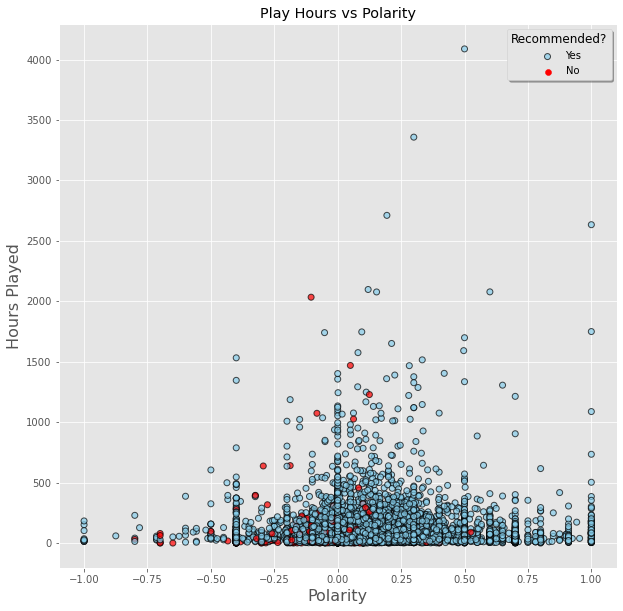

In [118]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=df.Polarity, y=df.PlayHours, alpha=0.7, hue=df.Review, edgecolor='black', palette=['red', 'skyblue'], linewidth=1)
plt.title('Play Hours vs Polarity')
plt.legend(['Yes', 'No'], title='Recommended?', shadow=True, title_fontsize=12, fancybox=True)
plt.ylabel('Hours Played', size=16)
plt.xlabel('Polarity', size=16)

Text(0, 0.5, 'Play Hours')

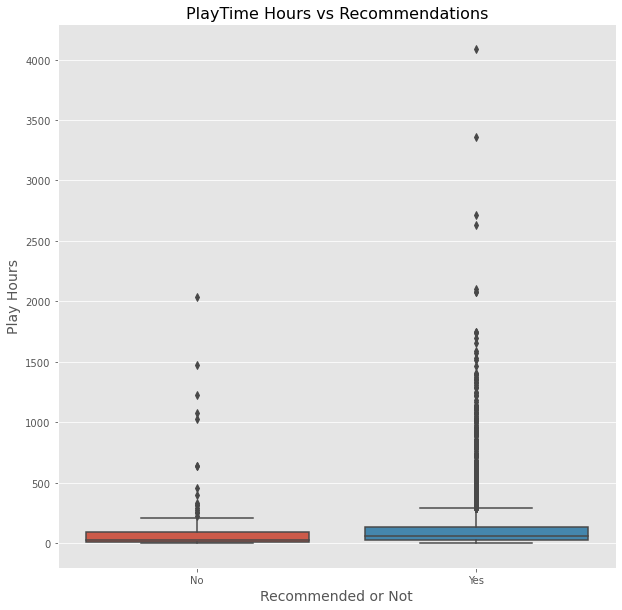

In [21]:
# instiate the plot
plt.figure(figsize=(10,10))
sns.boxplot(x=df.Review, y=df.PlayHours)
plt.title('PlayTime Hours vs Recommendations', size=16)
plt.xlabel('Recommended or Not', size=14)
# creating a custom label 
plt.xticks([0,1], ['No', 'Yes'])
plt.ylabel('Play Hours', size=14)

Off the bat, there is a large number of outliers for both decisions. It seems that around the 250 hour playtime mark, outliers go as far as 4000 hours for recommended games, and 2000 for the latter. 

The maximum of the distribution in both scenarios seem to be around the 500 hour point. We'll adjust the range of the y value so that we can see the boxplot information more clearly. 

(0.0, 500.0)

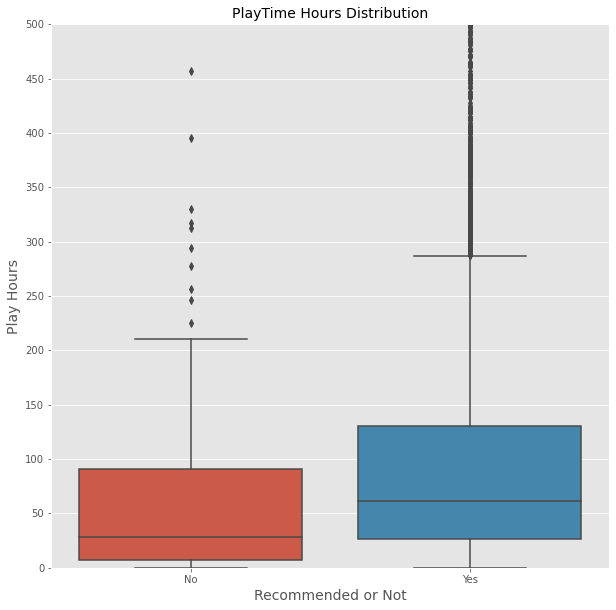

In [16]:
# instantiate the boxplot
plt.figure(figsize=(10,10))
sns.boxplot(x=df.Review, y=df.PlayHours)
plt.title('PlayTime Hours Distribution', size=14)
plt.xlabel('Recommended or Not', size=14)
# create custom label
plt.xticks([0,1], ['No', 'Yes'])
# customer y ticks
plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
# plt.yscale('log')
plt.ylabel('Play Hours', size=14)
# create y limit of 500 hours
plt.ylim(0,500)

#### Boxplots of PlayTime vs Recommendations

The plots shown above visually describe the statistical overview that we explored earlier. In order to visually understand a boxplot, I've attached a visual guide. 

<center><img src="boxplot_describe.png"/></center>


From the plot, we can see that for those that didn't like the game, the maximum value is around 200 hours, whereas for those the loved the game is around 300 hours. There aren't a lot of players that play more than 300 hours on average, and they are considered outliers (because there are less than 20 people that are in this group for both scenarios). 

However, we'll leave these values in the dataframe for EDA purposes. When we begin feature engineering (potentially) for our machine learning models, we'll most likely remove these outliers for a more accurate prediction. 

### Does Receiving the Game for Free Impact Recommendations? 

Another worthy area to look into is those that received the game for free, and see if they played the game for a good period of time (say around 10 hours), and if they recommended the game or not. Does the standard deviation in those that received the game for at no cost have a similar distribution of play hours vs those that purchased the game? 

We'll begin by creating a new column where numpy finds the phrase, "Product received for free" inside the `ReviewText` column. If it appears in there, then a value of 1 is assigned, else 0. 

In [17]:
# creating a new column where (1, 0) is assigned if the user received the game free of charge or not
df['ReceivedFree'] = np.where(df.ReviewText.str.contains('Product received for free'), 1, 0)

# sanity check to see how many users received the game for free
df[df.ReceivedFree == 1]


,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted,Polarity,Subjective,ReceivedFree
14,Product received for free\r\n\r\nit good,1,48,11.0,August 3,0.550000,0.700000,1
31,Product received for free\r\n\r\nyes,1,45,4.0,August 2,0.400000,0.800000,1
68,Product received for free\r\n\r\nMUST EXPAND F...,1,191,88.4,August 1,0.781250,0.800000,1
138,Product received for free\r\n\r\nGreat relaxin...,1,270,2711.1,July 31,0.193939,0.637121,1
230,Product received for free\r\n\r\nits ment for ...,1,72,7.3,July 28,0.400000,0.800000,1
...,...,...,...,...,...,...,...,...
5834,Product received for free\r\n\r\nThis game is ...,1,85,6.5,April 20,0.225000,0.500000,1
5912,Product received for free\r\n\r\ni like it,1,49,31.8,April 20,0.400000,0.800000,1
6058,Product received for free\r\n\r\nI like it cau...,1,101,5.2,April 19,0.550000,0.700000,1
6076,Product received for free\r\n\r\nbuild factory...,1,94,21.0,April 19,0.466667,0.600000,1


There are 105 users in this dataframe that received the game for free! I wonder how many of these reviews have users that did NOT recommend the game, but still received it for free. 

In [18]:
df[(df.ReceivedFree == 1) & (df.Review == 0)]


,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted,Polarity,Subjective,ReceivedFree
640,Product received for free\r\n\r\n♥♥♥♥♥♥♥,0,49,28.9,July 18,0.400000,0.800000,1
4118,Product received for free\r\n\r\nIF YOU LOVE S...,0,314,457.4,May 15,0.082292,0.642708,1
5076,Product received for free\r\n\r\nCRinge,0,48,4.2,April 30,0.400000,0.800000,1


There are only 3 users that did not recommend the game, despite receiving it for free. Let's take a look at the standard deviation between the two groups. 


In [19]:
# standard deviation for those that received the game for free
df[df.ReceivedFree == 1].std()

Review                   0.167398
ReviewLength(Chars)    198.155134
PlayHours              308.922792
Polarity                 0.156027
Subjective               0.135098
ReceivedFree             0.000000
dtype: float64

In [20]:
# standard deviation for those that purchased the game
df[df.ReceivedFree == 0].std()

Review                   0.174960
ReviewLength(Chars)    318.129443
PlayHours              188.619638
Polarity                 0.279122
Subjective               0.272719
ReceivedFree             0.000000
dtype: float64

Between the two groups, we can see that the standard deviation for people that received the game for free is significantly higher than those that purchased the game with their hard-earned dollars. This essentially means that the range of `PlayHours` has quite a bit of variance (as we can tell above with only three people that got the game for free, that have a range of around 5 to 460 hours).  


Now that we've created our new column, we'll remove the string containing 'Product received for free' inside the `ReviewText` column as an early measure of text cleaning. 

In [21]:
# removing the string "product received for free" inside the review content column
df.ReviewText = df.ReviewText.str.replace('Product received for free\r\n\r\n', '')

# sanity check
df[df.ReceivedFree == 1]


,ReviewText,Review,ReviewLength(Chars),PlayHours,DatePosted,Polarity,Subjective,ReceivedFree
14,it good,1,48,11.0,August 3,0.550000,0.700000,1
31,yes,1,45,4.0,August 2,0.400000,0.800000,1
68,MUST EXPAND FACTORY. DRIVE OUT THE LOCALS. KIL...,1,191,88.4,August 1,0.781250,0.800000,1
138,Great relaxing game with strong modding commun...,1,270,2711.1,July 31,0.193939,0.637121,1
230,its ment for develapers or thinkers,1,72,7.3,July 28,0.400000,0.800000,1
...,...,...,...,...,...,...,...,...
5834,"This game is good, but multiplayer crashes so ...",1,85,6.5,April 20,0.225000,0.500000,1
5912,i like it,1,49,31.8,April 20,0.400000,0.800000,1
6058,I like it cause it is good for like people who...,1,101,5.2,April 19,0.550000,0.700000,1
6076,build factory then build more factory then bui...,1,94,21.0,April 19,0.466667,0.600000,1


Now we can start getting into cleaning our text data more viscerally, and glean some insights. Before getting into it, we'll adjust the order of the columns of our dataframe. 

In [22]:
# changing the order of columns
df = df[['ReviewText', 'ReviewLength(Chars)', 'PlayHours', 'DatePosted', 'ReceivedFree', 'Review']]

# sanity check
df.head()

,ReviewText,ReviewLength(Chars),PlayHours,DatePosted,ReceivedFree,Review
0,0yuyou9yfui9ftrygyg6ftdryujiouhyeasrtgf4r,59,36.6,August 3,0,1
1,Hm.I think it's a good game,40,24.3,August 3,0,1
2,I uhh....... already feel my body getting fatter,59,21.7,August 3,0,1
3,"Its pretty cool, really slow however in the st...",60,4.4,August 3,0,1
4,very good,26,5.6,August 3,0,1


### Taking a Look at the Text Data
Before cleaning the data, let's see if we can get some information such as: 

- `CountWords` : The number of words in the review content
- `CountCapitalWords`: The number of uppercase words (like shouting, or expressing negative emotions)
- `CountExclQuestMarks`: The number of question or exclamation marks
- `CountEmojis`: The number of emojis in the corpus

We'll use a relatively simple helper function to apply the regex patterns needed from the each row of the data using a lambda function and `apply()`. 

In [23]:
def count_regex(pattern, text):
    '''Take in the regex pattern, and the text to return the count of the particular pattern'''
    return len(re.findall(pattern, text))

In [24]:
# count the number of words in the corpus
count_words = df.ReviewText.apply(lambda x: count_regex(r'\w+', x))
# count the number of capital words in the corpus
count_capital_words = df.ReviewText.apply(lambda x: count_regex(r'\b[A-Z]{2,}\b', x))
# count the number of question or exclamation marks
count_excl_quest_marks = df.ReviewText.apply(lambda x: count_regex(r'!|\?', x))
# count the number of emoji's in the corpus
count_emojis = df.ReviewText.apply(lambda x: emoji.demojize(x)).apply(lambda x: count_regex(r':[a-z_&]+:', x))

#create new dataframe 
df2 = pd.DataFrame({'count_words': count_words
                , 'count_capital_words': count_capital_words
                , 'count_excl_quest_marks': count_excl_quest_marks
                , 'count_emojis': count_emojis
                , 'Review': df.Review
                })

In [25]:
# sanity check
df2.head()

,count_words,count_capital_words,count_excl_quest_marks,count_emojis,Review
0,1,0,0,0,1
1,8,0,0,0,1
2,8,0,0,0,1
3,9,0,0,0,1
4,2,0,0,0,1


We've created a new dataframe containing information about the number of words, how many capital words were used, the number of exclamation marks or question marks used, and the number of emojis. Let's learn more about what they contain. The range of the values might be too far in between to plot clearly, so we'll pull some basic descriptive statistics for each of the new columns created. We'll be creating another helper function to streamline the process. 

In [26]:
def show_dist(df2, col):
    '''Take in the dataframe, and the column to return the descriptive statistics, grouped on the 'Review' column'''
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    # prints the descriptive statistics for a particular column, grouped on the Review column
    print(df2.groupby('Review')[col].describe())


In [27]:
# show descriptive stats for CountWords column
show_dist(df2, 'count_words')

Descriptive stats for count_words
---------------------------------
         count       mean         std  min  25%   50%   75%     max
Review                                                             
0        195.0  89.594872  160.175693  0.0  9.5  33.0  97.0  1354.0
1       5985.0  25.872348   62.900280  0.0  3.0   8.0  24.0  1376.0


In [28]:
# show descriptive stats for CountEmojis column
show_dist(df2, 'count_emojis')

Descriptive stats for count_emojis
----------------------------------
         count      mean       std  min  25%  50%  75%   max
Review                                                      
0        195.0  0.610256  2.848747  0.0  0.0  0.0  0.0  26.0
1       5985.0  0.131495  1.306191  0.0  0.0  0.0  0.0  52.0


In [29]:
# show descriptive stats for CountExclQuestMarks column
show_dist(df2, 'count_excl_quest_marks')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
         count      mean       std  min  25%  50%  75%    max
Review                                                       
0        195.0  0.338462  1.138958  0.0  0.0  0.0  0.0   12.0
1       5985.0  0.345029  3.837145  0.0  0.0  0.0  0.0  278.0


In [30]:
# show descriptive stats for CountCapitalWords column
show_dist(df2, 'count_capital_words')

Descriptive stats for count_capital_words
-----------------------------------------
         count      mean       std  min  25%  50%  75%    max
Review                                                       
0        195.0  0.753846  2.192048  0.0  0.0  0.0  0.0   18.0
1       5985.0  0.394820  3.034121  0.0  0.0  0.0  0.0  180.0


#### An Overview of Descriptive Statistics

- **The number of words** used have variance between those that recommend the game, and those that didn't. The maximum number of words used was 1376, for a positive review - and 1354 for a negative review. However, there seems to be an average of more words for those that negatively reacted (89 words), and those that positively reacted (25 words). We'll have to see if these numbers change dramatically when we clean the data. Thankfully, we don't have to be terribly careful with taking away too many stopwords in this case (to preserve the corpus). 
- Most of the reviews didn't contain that many **emojis**, which we will remove in our cleaning process. 
- The positive reviews have significantly more **exclamations or question marks**, with a total of 278, than the negative ones which had 12.
- Once again, the amount of **capital words** is significantly more in positive reviews (180), rather than the negative (18). 

#### WordClouds

Now that we've taken a quick look at the text data before cleaning it, we can create some wordclouds to see the most frequently used words in the reviews. 



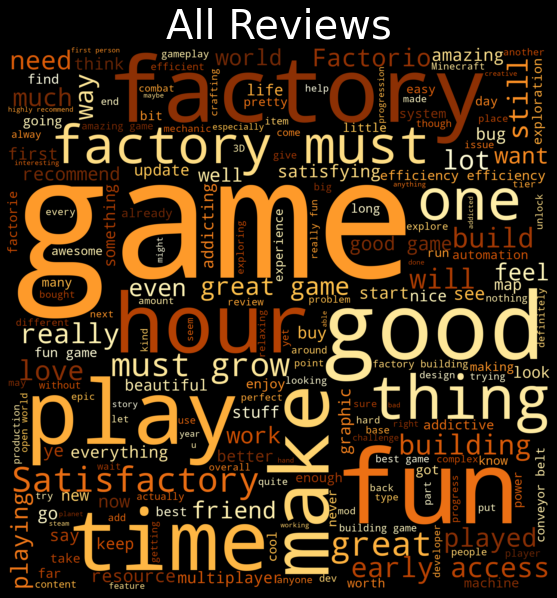

In [31]:
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(['br', 'href', 's'])
textt = " ".join(review for review in df.ReviewText)
wordcloud = WordCloud(stopwords=stopwords, background_color='black', mode="RGBA", width=2000, height=2000, colormap='YlOrBr').generate(textt)

fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('All Reviews', size=40, color='white')
plt.axis("off")
plt.show()


We can see that the most said words across the whole dataframe consist of "game", "fun", "good", "factory", "time", "play and "hour" among some of the popular ones. These words seem to express a positive sentiment toward the game. 

Now we'll split the dataframe into two separate dataframes for those the recommended the game, and those that didn't (labelled as "positive"  and "negative"). 

In [32]:
positive = df[df['Review'] == 1]
negative = df[df['Review'] == 0]


Let's create our WordCloud for the positive reviews. 

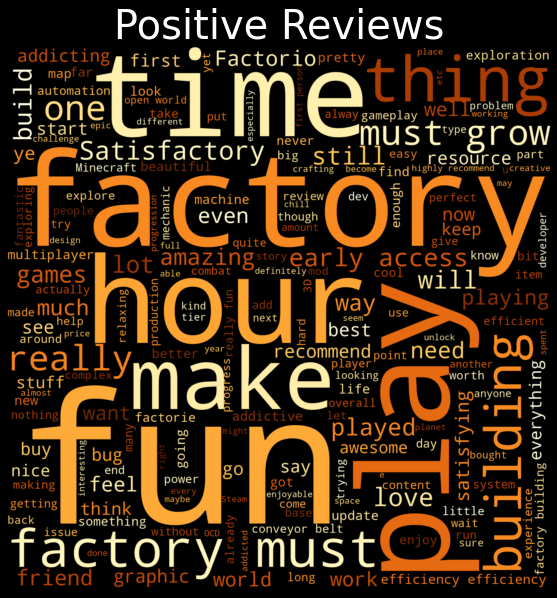

In [33]:
stopwords = set(STOPWORDS)
stopwords.update(['br', 'href', 'good', 'great', 'game', 's'])
# good, great, game were removed because they existed in both positive and negative reviews
pos = " ".join(review for review in positive.ReviewText)
wordcloud_pos = WordCloud(stopwords=stopwords, background_color='black', mode="RGBA", width=2000, height=2000, colormap='YlOrBr').generate(pos)

fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('black')
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews', size=40, color='white')
plt.axis("off")
plt.show()


Now we'll create our WordCloud for negative reviews. 

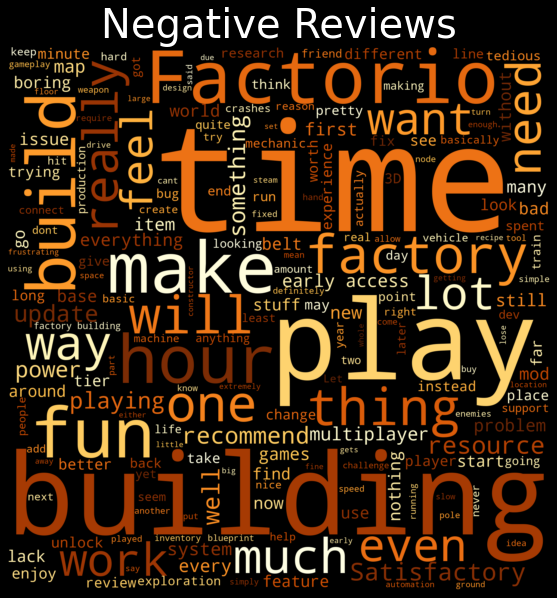

In [34]:
stopwords = set(STOPWORDS)
stopwords.update(['br', 'href', 'good', 'great', 'game', 's'])
# good, great, game were removed because they existed in both positive and negative reviews
neg = " ".join(review for review in negative.ReviewText)
wordcloud_neg = WordCloud(stopwords=stopwords, background_color='black', mode="RGBA", width=2000, height=2000, colormap='YlOrBr').generate(neg)

fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('black')
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews', size=40, color='white')
plt.axis("off")
plt.show()



### Text Cleaning 

Before we start using the text data, we need to clean it. We'll be focusing on: 

- setting all the words to **lowercase**
- remove all **punctuations**, including the exclamation and question marks
- the **emojis** will be converted to one word
- remove **digits**

We'll instantiate a few helper functions once again, in order to smooth the process further. 

In [35]:
class CleanText(BaseEstimator, TransformerMixin): 

    def emoji_oneword(self, text_input):
        # the underscore is compressed, and the emoji is kept as one word 
        return text_input.replace('_', '')

    def remove_punctuation(self, text_input):
        punct = string.punctuation
        # every punctuation will be replace by a space
        table = str.maketrans(punct, len(punct)* ' ')
        return text_input.translate(table)

    def remove_digits(self, text_input): 
        # removes digits
        return re.sub('\d+', '', text_input)

    def to_lower(self, text_input): 
        # puts text into lowercase
        return text_input.lower()

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        X_clean = X.apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower)
        return X_clean

In [36]:
# instantiate the class method
ct = CleanText()
# fit and transform the 'ReviewText' column
review_clean = ct.fit_transform(df.ReviewText)

# sanity check
review_clean.head()

0                 yuyouyfuiftrygygftdryujiouhyeasrtgfr
1                          hm i think it s a good game
2     i uhh        already feel my body getting fatter
3    its pretty cool  really slow however in the st...
4                                            very good
Name: ReviewText, dtype: object

In [37]:
# assign cleaned text to review text column
df.ReviewText = review_clean

# sanity check 
df

,ReviewText,ReviewLength(Chars),PlayHours,DatePosted,ReceivedFree,Review
0,yuyouyfuiftrygygftdryujiouhyeasrtgfr,59,36.6,August 3,0,1
1,hm i think it s a good game,40,24.3,August 3,0,1
2,i uhh already feel my body getting fatter,59,21.7,August 3,0,1
3,its pretty cool really slow however in the st...,60,4.4,August 3,0,1
4,very good,26,5.6,August 3,0,1
...,...,...,...,...,...,...
6175,it is such a complex grinding game,48,157.2,April 18,0,1
6176,terrible early access game literally nothing ...,63,394.7,April 18,0,1
6177,bean,22,186.1,April 18,0,1
6178,this game tells me that i have too much free time,57,143.8,April 18,0,1


#### Most Common Words (with stopwords)

Now that we've removed several things like emojis, punctuation, digits, and transformed the text to lowercase, we can attempt to plot the most common words said (without the removal of stopwords) across all reviews. 

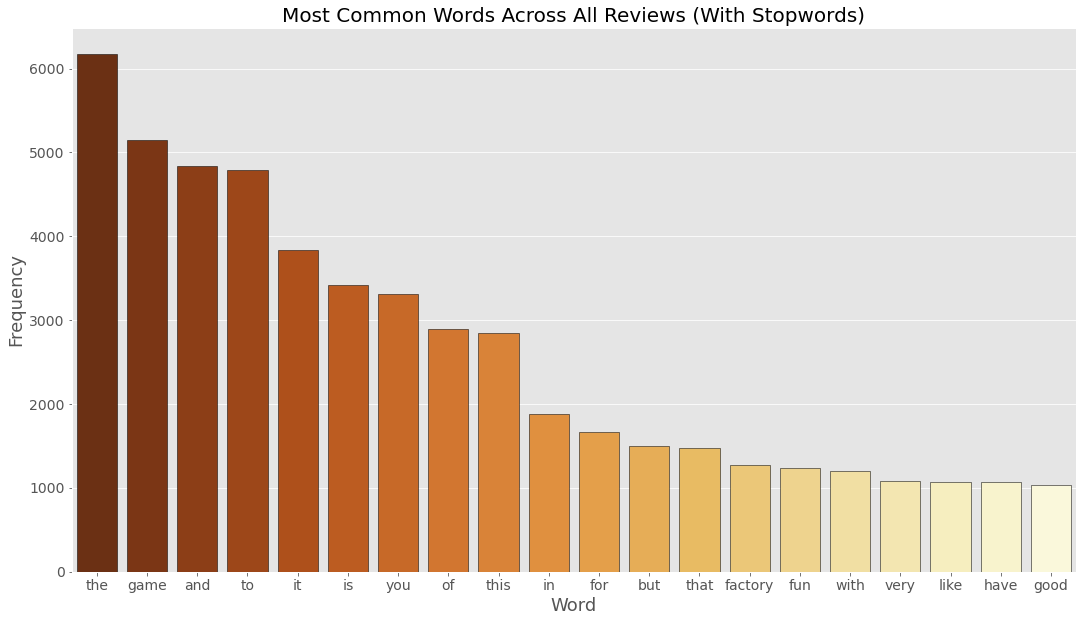

In [38]:
cv = CountVectorizer()
bow = cv.fit_transform(df.ReviewText)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(18, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="YlOrBr_r", ax=ax, edgecolor='black')
plt.title('Most Common Words Across All Reviews (With Stopwords)', size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Word', size=18)
plt.ylabel('Frequency', size=18)
plt.show();


#### Removing Stopwords
We can see that there are quite a few filler words that aren't important to us, as they are known as "stopwords". We'll be removing the stopwords next. 

In [39]:
# getting the stopwords set
from nltk.corpus import stopwords
stop = stopwords.words('english')
# adding in some stopwords that aren't in the nltk library but are relevant to the corpus 
new_stopwords = ["n't", "good", "great", "game", "games", "factory", "satisfactory"]
stop.extend(new_stopwords)

# creating new column with review text containing no stopwords
df['No_StopWords_Review'] = df['ReviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

We've successfully removed the stopwords from the review text column (and created a new column to compare against). Let's visualize the top 20 words used for positive and negative reviews before we delve deeper into lemmatization in preparation for topic modelling. 

In [40]:
# separating the dataframe into positive and negative reviews 
positive = df[df['Review'] == 1]
negative = df[df['Review'] == 0]

# sanity check
print(f"There are {len(positive.columns)} columns and {len(positive.index)} rows for positive reviews.")
print(f"There are {len(negative.columns)} columns and {len(negative.index)} rows for negative reviews.")

There are 7 columns and 5985 rows for positive reviews.
There are 7 columns and 195 rows for negative reviews.


#### Most Common Words Across All Reviews
Now that we've separated the dataframes for positive and negative sentiments, we'll now plot the most common words said for each dataframe (including all reviews, because we've removed stopwords). 

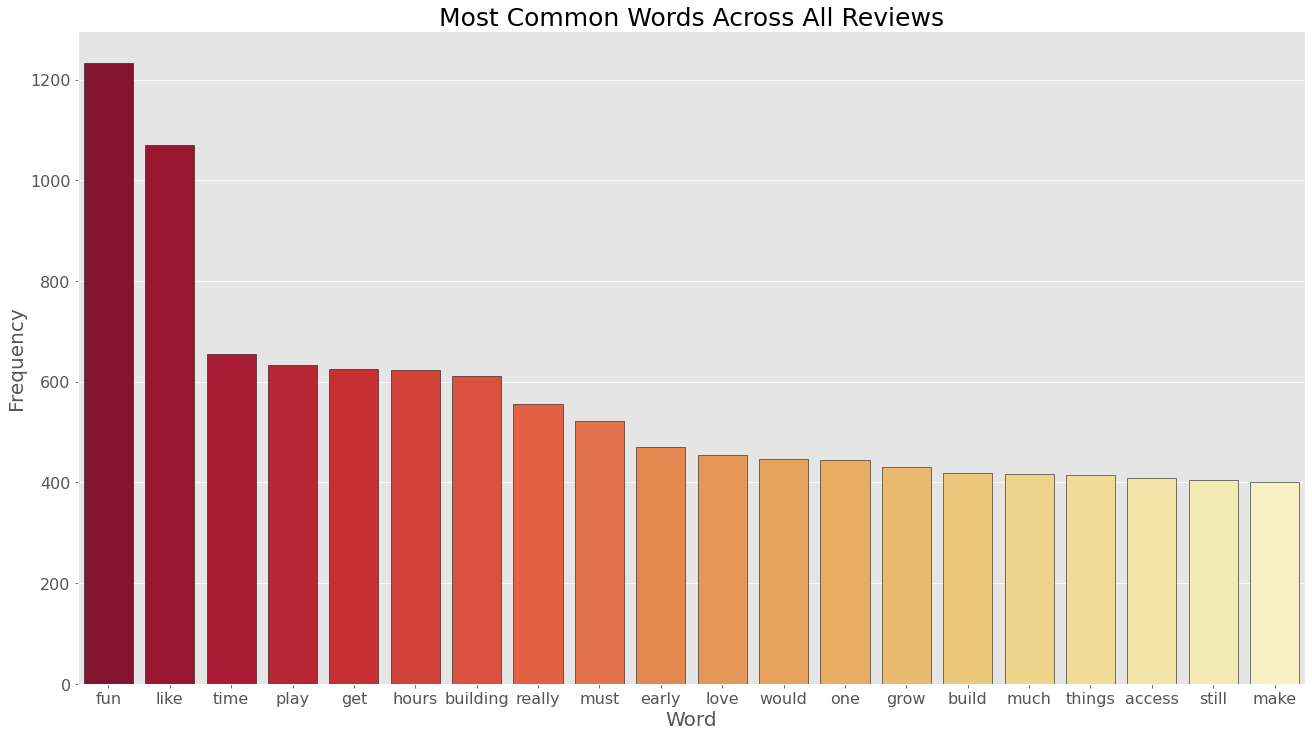

In [41]:
# using bag of words method (most common words across the whole corpus)
cv = CountVectorizer()
bow = cv.fit_transform(df.No_StopWords_Review)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(22, 12))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette='YlOrRd_r', ax=ax, edgecolor='black')
plt.title('Most Common Words Across All Reviews', size=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Word', size=20)
plt.ylabel('Frequency', size=20)
plt.show();

Words like, "fun", "like", "time", "play", "get" and "hours" are among the most used across ALL of the reviews. Let's see where the brunt of these words are being used, are they mostly in positive or negative reviews? 

#### Most Common Words for Positive Reviews
Let's plot the most common words for positive reviews now. 

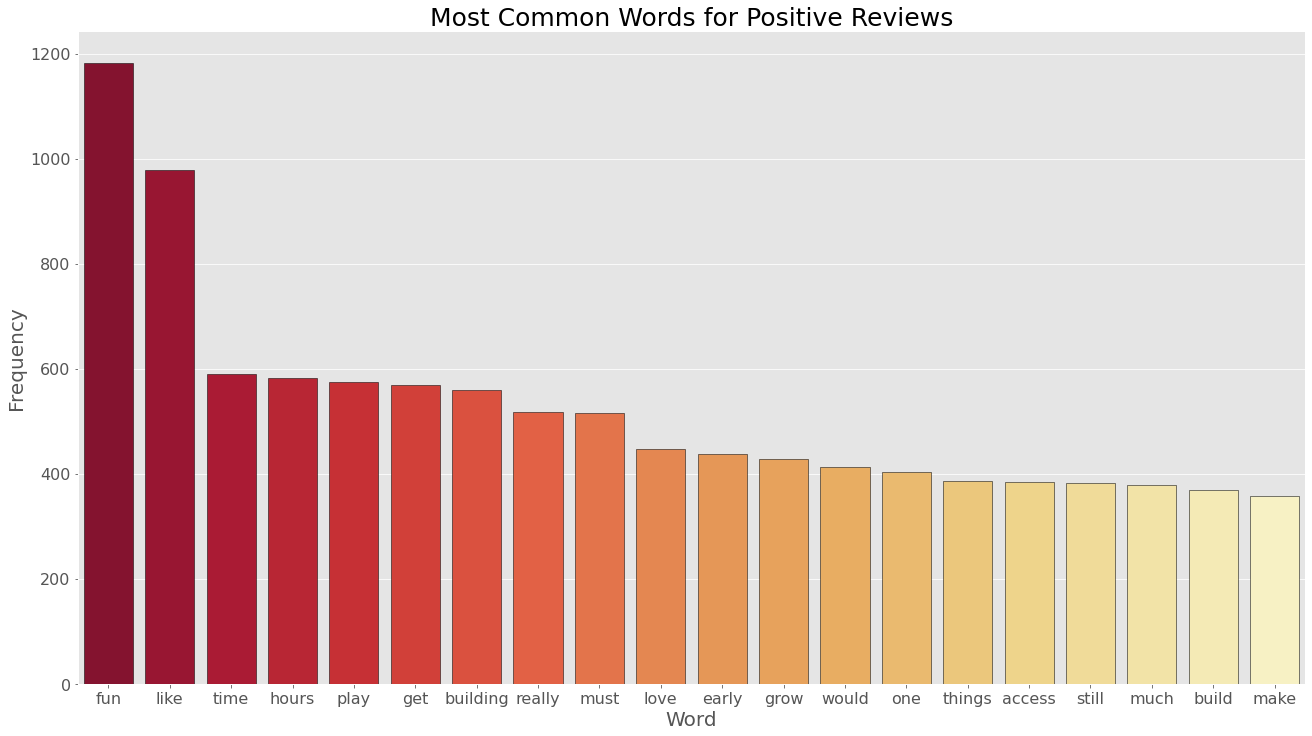

In [42]:
cv = CountVectorizer()
bow = cv.fit_transform(positive.No_StopWords_Review)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(22, 12))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="YlOrRd_r", ax=ax, edgecolor='black')
plt.title('Most Common Words for Positive Reviews', size=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Word', size=20)
plt.ylabel('Frequency', size=20)
plt.show();

#### Most Common Words for Negative Reviews 

For positive reviews, "fun", "like", "time, "hours", "play", "get" and "building" seem to be the most common words. Let's see if there a similar words being used for negative reviews. 

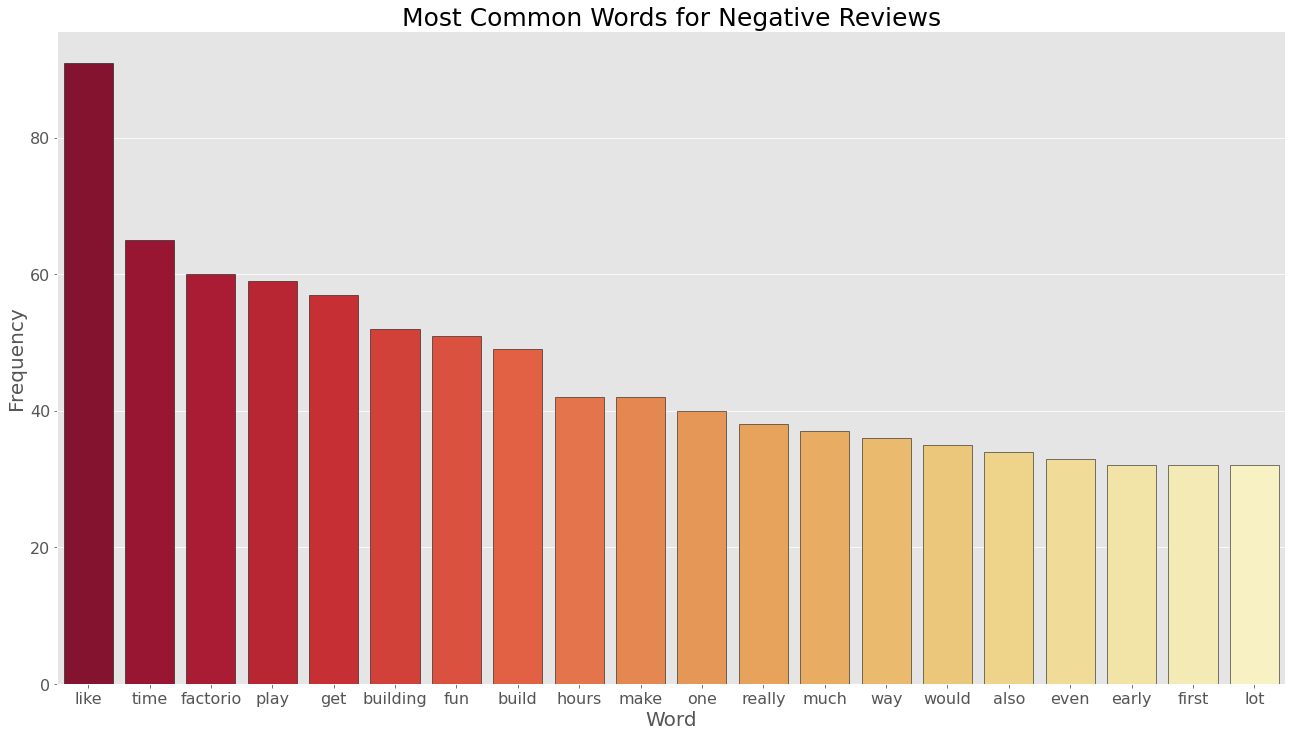

In [43]:
cv = CountVectorizer()
bow = cv.fit_transform(negative.No_StopWords_Review)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(22, 12))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="YlOrRd_r", ax=ax, edgecolor='black')
plt.title('Most Common Words for Negative Reviews', size=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Word', size=20)
plt.ylabel('Frequency', size=20)
plt.show();

For negative reviews, we see some similarities in words being used, such as - "like", "time", "factorio", "play", "get" and "building" are most commonly used. Even though these words are used in both positive and negative reviews, since this is a factory building game - we have reason to believe that these words are descriptive of the game, rather than sentiment. 

#### N-grams for Positive and Negative Reviews

Before moving forward with topic modelling, let's take a look at the most occuring word combinations (n-grams) for both positive and negative reviews. This can help us narrow down specific topics and sentiments, further. 

Firstly, even though we've successfully did some cleaning such as removing emojis, punctuation, digits, and transforming the text to lowercase - we haven't performed any lemmatization. Essentially, lemmatisizing is the process of transforming words to their root. For example, "running" would be changed to "run". 

So we're creating another helper function as an additional measure to effectively clean the data even further than before. 


In [44]:
ADDITIONAL_STOPWORDS = ['covfefe', "n't", "good", "great", "game", "games", "factory", "satisfactory"]

def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [45]:
# calling the helper function to process the positive text words and create a list
words_pos = basic_clean(''.join(str(positive.No_StopWords_Review.tolist())))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
# sanity check
words_pos[:10]

['yuyouyfuiftrygygftdryujiouhyeasrtgfr',
 'hm',
 'think',
 'uhh',
 'already',
 'feel',
 'body',
 'getting',
 'fatter',
 'pretty']

In a simple line of code, we can find out which bigrams occur the most in positive reviews. 

In [47]:
# pulling top word pairs (bigrams)
bigrams_pos =(pd.Series(nltk.ngrams(words_pos, 2)).value_counts())

# taking a look
bigrams_pos[:10]

<IPython.core.display.Javascript object>

(must, grow)                411
(early, access)             381
(grow, must)                373
(efficiency, efficiency)    159
(conveyor, belt)            113
(longer, longer)             91
(really, fun)                86
(feel, like)                 81
(would, recommend)           78
(open, world)                76
dtype: int64

We can also modify the same line of code to get more word combinations, such as trigrams. 

In [48]:
# pull trigrams from positive reviews
trigrams_pos = (pd.Series(nltk.ngrams(words_pos, 3)).value_counts())

# taking a look
trigrams_pos

<IPython.core.display.Javascript object>

(must, grow, must)                      373
(grow, must, grow)                      369
(efficiency, efficiency, efficiency)    158
(longer, longer, longer)                 90
(still, early, access)                   60
                                       ... 
(time, hardly, feel)                      1
(hardly, feel, pre)                       1
(feel, pre, release)                      1
(pre, release, given)                     1
(hard, false, spot)                       1
Length: 67053, dtype: int64

Let's plot this information. 

### Topic Modelling with LDA

#### Preparing Data for LDA Analysis
Now we'll get into topic modelling with LDA (Latent Dirichlet Analysis). We'll begin by converting our REviews column into a list first, and then tokenizing the text so that the words are split up within a sentence in order for the LDA model to disnguish word pairs in order to find topics within the corpora. 

In [50]:
# create a list 
sf_reviews = df.No_StopWords_Review.values.tolist()

In [51]:
# sanity check
len(sf_reviews)

6180

In [52]:
# quick look
sf_reviews[:5]

['yuyouyfuiftrygygftdryujiouhyeasrtgfr',
 'hm think',
 'uhh already feel body getting fatter',
 'pretty cool really slow however start',
 '']

Now that we have our list ready, we can use the TfID vectorizer to transform the list into tokens for topic modelling the sklearn pyLDAvis package. We'll start by fitting the list into the vectorizer. 

In [53]:
# instantiate the tf_vectorizer
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(sf_reviews)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(sf_reviews)

Now that we've fit and transformed the list into the vectorizer, we'll now fit the model and see if we can pull twenty topics from the text data. 

In [54]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=5, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=5, random_state=0)

#### Topic Modelling for All Reviews (pyLDAvis)  

We've successfully fitted the models, now we'll visualize this information using the `pyLDAvis` package with sklearn. To interpret the visualizations, refer to this [documentation](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf) for a detailed explanation. 

Essentially, the visual elements compose of: 

*Default Topic Circles*
- Each circle represents a topic, whose area are set as proportional to all the topics across the total tokens in the corpus. They're displayed when a term is not selected. 
*Red Bars*
- The red horizontal bars represent the estimated number of times a given term was generated by the given topic. When the topic is selected, it only shows the red bars for the most relevant terms of the selected topic
*Blue Bars*
- The blue horizontal bars represent the overall frequency of each term in the corpus. When a topic isn't selected, it displays the blue bars for the most relevant terms in the corpus. However, when a term is selected, it shows the most relevant words assocatiated with the term. 
*Topic-Term Circles*
- When a term is selected, the circle adjusts according to the proportion of the frequencies in how the given term is selected by the topics. 

The slider on the topic right adjusted for relevancy, where the metric optimal value is around 0.6 according to this [documentation](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf). When the slider is increased closer to 1, the more generalized the terms become, and the closer it gets to 0, the more specific/descriptive. 

This holds all of the reviews (both recommended and not).

In [55]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)
# pyLDAvis.save_html(p, 'lda.html')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.135471  0.060743       1        1  32.424687
3      0.122133  0.095891       2        1  19.616047
1     -0.031039 -0.192680       3        1  17.597899
0      0.014260 -0.067585       4        1  16.536238
2     -0.240825  0.103632       5        1  13.825128, topic_info=           Term         Freq        Total Category  logprob  loglift
379         fun  1185.000000  1185.000000  Default  30.0000  30.0000
424        grow   409.000000   409.000000  Default  29.0000  29.0000
263  efficiency   242.000000   242.000000  Default  28.0000  28.0000
257       early   457.000000   457.000000  Default  27.0000  27.0000
5        access   398.000000   398.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
548        like    64.841432  1052.547720   Topic5  -4.6830  -0.8083
328         far    39.752296   160.081289   Topic5  -5.1723   0.5857
567        long    40.191094   176.031587   Topic5  -5.1613   0.5017
588        make    38.794042   395.146291   Topic5  -5.1967  -0.3423
851         say    36.513473   174.062974   Topic5  -5.2572   0.4169

[347 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
5         1  0.002510        access
5         2  0.007531        access
5         3  0.622555        access
5         4  0.366504        access
7         3  0.937537  achievements
...     ...       ...           ...
1098      5  0.885666          yeah
1099      3  0.227366          year
1099      5  0.727570          year
1101      1  0.987397           yes
1101      3  0.012879           yes

[736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

##### Overview on the Topics for All Reviews

- Topic 1/2: Tasks that a player undertakes in a game
- Topic 3: Playing with friends, having bugs in the game
- Topic 4: Time spent grinding the game, and how addictive it can be. 
- Topic 5: Talks about how satisfying the game is, how work can be fun (talks about planning, and math)?  

#### Topic Modelling for Positive Reviews 

Now, we'll do the same thing again for negative reviews to determine if there are significantly different topics or not among those that were satisfied with the game. 

In [56]:
# create a list 
sf_reviews_pos = positive.No_StopWords_Review.values.tolist()

In [57]:
# sanity check
len(sf_reviews_pos)

5985

In [58]:
# quick look
sf_reviews_pos[:5]

['yuyouyfuiftrygygftdryujiouhyeasrtgfr',
 'hm think',
 'uhh already feel body getting fatter',
 'pretty cool really slow however start',
 '']

Now that we have our list ready, we can use the TfID vectorizer to transform the list into tokens for topic modelling the sklearn pyLDAvis package. We'll start by fitting the list into the vectorizer. 

In [59]:
# instantiate the tf_vectorizer
tf_vectorizer_pos = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf_pos = tf_vectorizer_pos.fit_transform(sf_reviews_pos)
tfidf_vectorizer_pos = TfidfVectorizer(**tf_vectorizer_pos.get_params())
dtm_tfidf_pos = tfidf_vectorizer_pos.fit_transform(sf_reviews_pos)

Now that we've fit and transformed the list into the vectorizer, we'll now fit the model and see if we can pull twenty topics from the text data. 

In [60]:
# for TF DTM
lda_tf_pos = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf_pos.fit(dtm_tf_pos)
# for TFIDF DTM
lda_tfidf_pos = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tfidf_pos.fit(dtm_tfidf_pos)

LatentDirichletAllocation(n_components=4, random_state=0)

In [61]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


pyLDAvis.sklearn.prepare(lda_tf_pos, dtm_tf_pos, tf_vectorizer_pos)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.041297 -0.043512       1        1  47.700279
1      0.068821 -0.190587       2        1  21.148040
0     -0.256313  0.047977       3        1  16.109676
3      0.146195  0.186123       4        1  15.042005, topic_info=           Term         Freq        Total Category  logprob  loglift
352         fun  1126.000000  1126.000000  Default  30.0000  30.0000
101       build   363.000000   363.000000  Default  29.0000  29.0000
531        love   440.000000   440.000000  Default  28.0000  28.0000
243  efficiency   242.000000   242.000000  Default  27.0000  27.0000
104    building   540.000000   540.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
541       makes    46.425754   122.901157   Topic4  -4.9831   0.9208
886      things    65.649049   379.208545   Topic4  -4.6366   0.1406
838       start    43.547089   162.198833   Topic4  -5.0471   0.5793
666     playing    43.860862   295.602305   Topic4  -5.0399  -0.0137
433       hours    41.208871   569.752604   Topic4  -5.1023  -0.7322

[277 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5         1  0.997518     access
11        3  0.296359   addicted
11        4  0.691503   addicted
12        1  0.159166  addicting
12        2  0.682139  addicting
...     ...       ...        ...
989       3  0.665608      worth
991       4  0.970691      write
994       3  0.984077       yeah
995       2  0.939880       year
997       3  0.996782        yes

[459 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

##### Overview on the Topics for Positive Reviews

- Topic 1: Talks about the display of the game, how beautiful it is despite it being early access 
- Topic 2: Time spent grinding the game, and how addictive it can be. 
- Topic 3: Efficiency, spending hours of gameplay optimizing. Also talks about the price of the game being fair (and worth it)
- Topic 4: Building tasks, and objects related to factory building (automating, for example)


In [62]:
# create a list 
sf_reviews_neg = negative.No_StopWords_Review.values.tolist()

In [63]:
# sanity check
len(sf_reviews_neg)

195

In [64]:
# quick look
sf_reviews_neg[:5]

['way grindy play first time kill time need play lot cool stuff like grindy buy hate dedicate life',
 'imo dogs damn overpowered needs put something',
 '',
 'want compare factorio feel like factorio continually expanding way upgrades work steers toward progressively introducing new challenge automating one solved feels like know want trying stop much fun right away resources need far away passively craft things inventory walking around like factorio power sources limited early alien enemies health regen severely limit ability explore first several hours leads whole lot waiting around things happen puts many obstacles way early continually automate away tedium maybe gets better later maybe exceptionally poor job steering toward right way play sheer act making space make tedium introduced',
 'boring end goal purchase']

Now that we have our list ready,we can use the TfID vectorizer to transform the list into tokens for topic modelling the sklearn pyLDAvis package. We'll start by fitting the list into the vectorizer. 

In [65]:
# instantiate the tf_vectorizer
tf_vectorizer_neg = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf_neg = tf_vectorizer_neg.fit_transform(sf_reviews_neg)
tfidf_vectorizer_neg = TfidfVectorizer(**tf_vectorizer_neg.get_params())
dtm_tfidf_neg = tfidf_vectorizer_neg.fit_transform(sf_reviews_neg)

Now that we've fit and transformed the list into the vectorizer, we'll now fit the model and see if we can pull twenty topics from the text data. 

In [66]:
# for TF DTM
lda_tf_neg = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf_neg.fit(dtm_tf_neg)
# for TFIDF DTM
lda_tfidf_neg = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tfidf_neg.fit(dtm_tfidf_neg)

LatentDirichletAllocation(n_components=4, random_state=0)

In [67]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


pyLDAvis.sklearn.prepare(lda_tf_neg, dtm_tf_neg, tf_vectorizer_neg)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.033377  0.007168       1        1  52.550312
2     -0.006843 -0.197638       2        1  18.621918
0     -0.158251  0.109093       3        1  17.584374
1      0.198471  0.081377       4        1  11.243396, topic_info=           Term       Freq      Total Category  logprob  loglift
23          fun  50.000000  50.000000  Default  30.0000  30.0000
38  multiplayer  24.000000  24.000000  Default  29.0000  29.0000
13        early  32.000000  32.000000  Default  28.0000  28.0000
41         play  57.000000  57.000000  Default  27.0000  27.0000
0        access  25.000000  25.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
68        worth   1.225222  15.393111   Topic4  -5.0133  -0.3454
18          far   1.354646  17.259246   Topic4  -4.9129  -0.3594
30         long   1.407731  21.161392   Topic4  -4.8745  -0.5248
26        hours   2.344525  41.331887   Topic4  -4.3644  -0.6842
33         make   1.996310  41.288236   Topic4  -4.5252  -0.8439

[164 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         3  0.950064    access
1         1  0.445236  actually
1         2  0.445236  actually
1         3  0.074206  actually
2         1  0.453404       bad
...     ...       ...       ...
67        4  0.094752     world
68        1  0.454749     worth
68        2  0.194892     worth
68        3  0.324821     worth
68        4  0.064964     worth

[176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

##### Overview on the Topics for Negative Reviews

- Topic 1: Mentions similarity with another game, Factorio (especially about gameplay elements). 
- Topic 2: Time spent grinding the game, and how tedious it can be. 
- Topic 3: Talks about Early Access issues needed to be fixed, and how some players preferred to use mods. 
- Topic 4: Multiplayer gameplay, bugs

In [68]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split()

In [69]:
df_text = df.drop(['ReviewText', 'DatePosted', 'ReviewLength(Chars)', 'PlayHours'], axis=1)

In [70]:
df_text

,ReceivedFree,Review,No_StopWords_Review
0,0,1,yuyouyfuiftrygygftdryujiouhyeasrtgfr
1,0,1,hm think
2,0,1,uhh already feel body getting fatter
3,0,1,pretty cool really slow however start
4,0,1,
...,...,...,...
6175,0,1,complex grinding
6176,0,1,terrible early access literally nothing
6177,0,1,bean
6178,0,1,tells much free time


In [71]:
# separate df into features and target variable
y = df['Review']
# drop the target variable from the X dataframe (remaining features)
X = df.drop('Review',axis=1)